# Learn Sleep Phases Cycles

In [1]:
%pylab inline

import pandas as pd

Populating the interactive namespace from numpy and matplotlib


In [2]:
lab = pd.read_csv('./dataset/label.csv', sep=';', index_col=0)

## Patient Decomposition

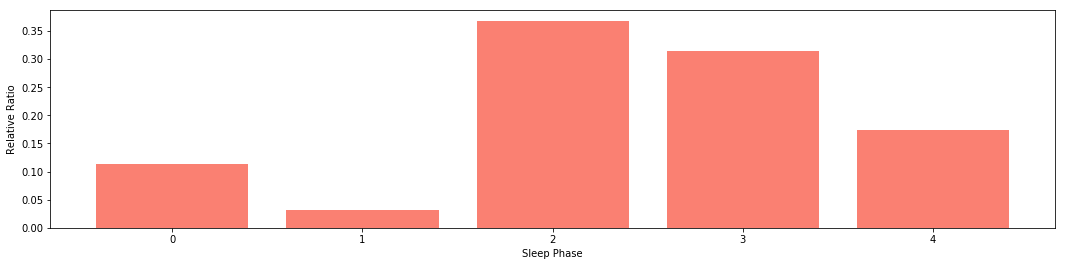

In [3]:
prp = [len(np.where(lab == idx)[0]) / len(lab) for idx in np.unique(lab)]

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(prp)), prp, color='salmon')
plt.xlabel('Sleep Phase')
plt.ylabel('Relative Ratio')
plt.show()

In [6]:
from itertools import groupby

def build_profiles(labels):

    lst = [list(grp) for k, grp in groupby(labels)]
    s_p = np.asarray([ele[0] for ele in lst])
    sms = np.asarray([len(ele) for ele in lst])
    ind = np.where(s_p == 0)[0]

    idx = np.asarray(sorted(list(set(np.where(sms > 10)[0]) & set(ind))))
    mea = np.mean(np.diff(np.cumsum(sms)[idx]) * 30) / 60 / 60
    print('# Mean Duration of Night per Person: {} hours'.format(np.round(mea, 1)))

    prf, mkr = [], []
    for pat in range(len(idx)-1):
        dec = np.asarray([0] + list(np.cumsum(sms)))
        beg, end = max(0, dec[idx[pat]] + sms[idx[pat]] // 2), min(len(lab), dec[idx[pat+1]] + sms[idx[pat+1]] // 2)
        mkr.append((beg, end))
        prf.append(labels[beg:end])
        
    return prf, mkr

prf, mkr = build_profiles(lab.values.ravel())

# Mean Duration of Night per Person: 4.1 hours


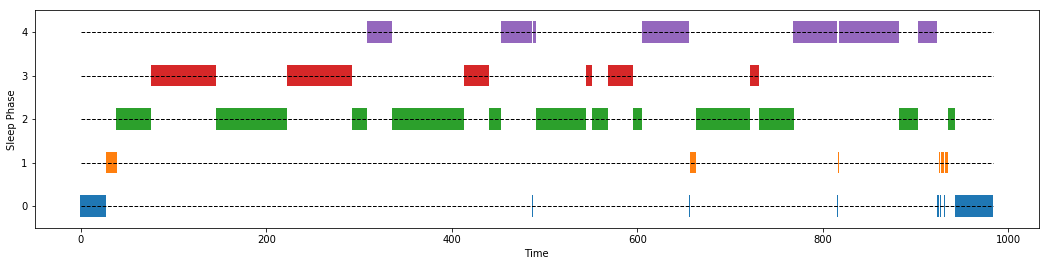

In [20]:
def display_profile(profile):

    plt.figure(figsize=(18,4))
    ind = np.arange(len(profile))
    for idx in np.unique(profile):
        plt.hlines(idx, 0, len(profile), linestyles='--', lw=1.0)
        ext = np.where(profile == idx)[0]
        plt.bar(ind[ext], 0.5, bottom=profile[ext]-0.25, width=1.2)
    plt.ylim([-0.5, 4.5])
    plt.xlabel('Time')
    plt.ylabel('Sleep Phase')
    plt.show()
    
display_profile(prf[-16])

In [ ]:
import multiprocessing

def entropy(vector, rnd=5, bss=None):
    
    _,c = np.unique(np.round(vector, rnd), return_counts=True)
    cnt = c / c.sum()
    bss = 10 if bss is None else bss

    return -(cnt * np.log(cnt) / np.log(bss)).sum()

## Learn Sleep Phases

In [ ]:
import keras
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense

In [ ]:
res, dim = [], 31

for profile in prf:
    m_i = np.arange(dim)*(0+1)
    m_j = np.arange(np.max(profile.shape[0]-(dim-1)*(0+1), 0))
    res.append(profile[m_i + m_j.reshape(-1,1)])
    
res = np.vstack(tuple(res))
vec = to_categorical(res)
x,y = vec[:,:dim-1,:], vec[:,-1,:]
print(x.shape, y.shape)
x_t, x_v, y_t, y_v = train_test_split(x, y, test_size=0.33, shuffle=True)

In [ ]:
model = Sequential()
model.add(LSTM(30, input_shape=(x_t.shape[1], x_t.shape[2]), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(30, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
model.fit(x_t, y_t, epochs=3, batch_size=32, shuffle=True, validation_data=(x_v, y_v))

## Artifacts Removal | Clearing

In [24]:
from scipy.interpolate import interp1d

def interpolate(val, size=1000):

    x = np.linspace(0, size, num=len(val), endpoint=True)
    o = np.linspace(0, size, num=size, endpoint=True)

    if len(val) < size:
        f = interp1d(x, val, kind='linear', fill_value='extrapolate')
        return f(o)

    if len(val) == size:
        return val

    if len(val) > size:
        f = interp1d(x, val, kind='quadratic')
        return f(o)
    
def mp_interpolate(val):
    
    pol = multiprocessing.Pool(processes=multiprocessing.cpu_count())
    res = np.asarray(pol.map(interpolate, val))
    pol.close()
    pol.join()
    
    return res

def outlier_from_median(ele, threshold):
        
    val = np.abs(ele - np.median(ele))
    val = val / np.median(val) if np.median(val) else 0.0
    
    return np.where(val > threshold)[0]

### General Outlier Identification

In [27]:
import h5py

e_key = ['eeg_{}'.format(dim) for dim in range(1, 5)]

with h5py.File('./dataset/train.h5', 'r') as dtb:
    eeg_t = np.asarray([dtb[key].value for key in e_key])
    nrm_t = np.sqrt(np.sum(np.square(eeg_t), axis=0))

with h5py.File('./dataset/valid.h5', 'r') as dtb:
    eeg_v = np.asarray([dtb[key].value for key in e_key])
    nrm_v = np.sqrt(np.sum(np.square(eeg_v), axis=0))

eeg_s = np.concatenate((eeg_t, eeg_v), axis=1)
nrm_s = np.vstack((nrm_t, nrm_v))

In [79]:
lbl = lab.values.ravel()
msk = np.ones(len(nrm_t) + len(nrm_v), dtype=bool)

m_x = np.max(nrm_s, axis=1)
grd = np.max(np.gradient(nrm_s, axis=1), axis=1)
auc = np.trapz(nrm_s, axis=1)

msk[outlier_from_median(m_x, 4)] = False
msk[outlier_from_median(grd, 4)] = False
msk[outlier_from_median(auc, 4)] = False

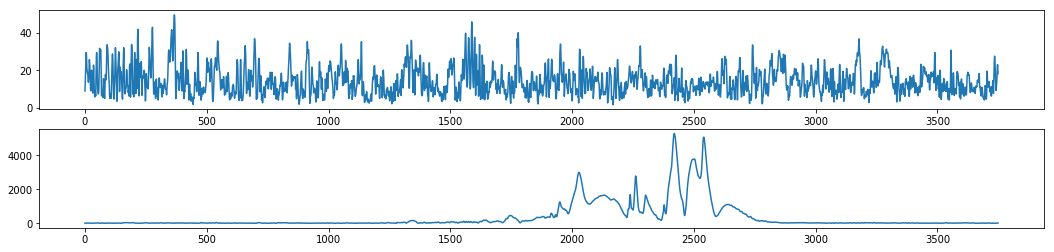

In [80]:
i_t, i_f = np.random.choice(np.where(msk)[0]), np.random.choice(np.where(np.invert(msk))[0])

plt.figure(figsize=(18,4))
plt.subplot(2,1,1)
plt.plot(nrm_s[i_t])
plt.subplot(2,1,2)
plt.plot(nrm_s[i_f])
plt.show()

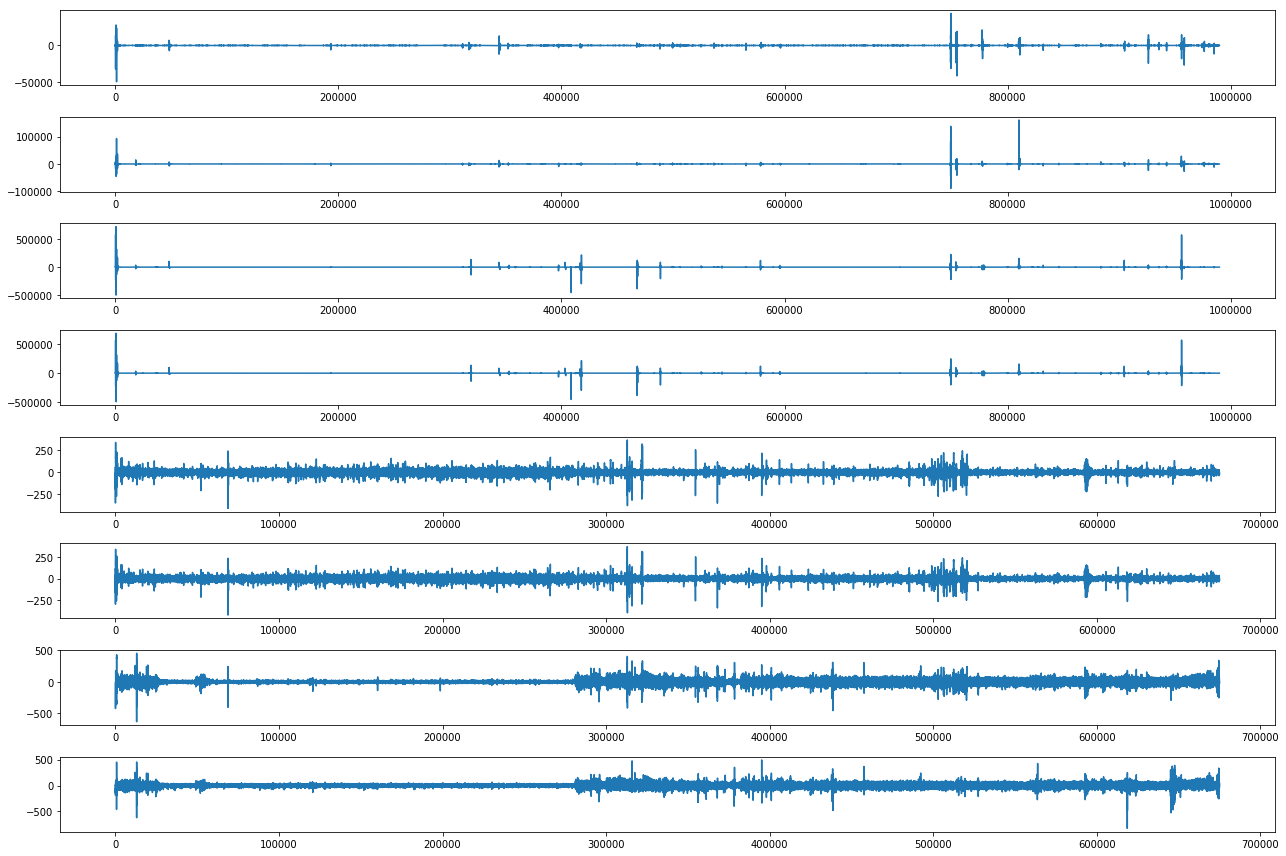

In [81]:
beg, end = mkr[np.random.choice(np.arange(len(mkr)))]

plt.figure(figsize=(18,12))
for i in range(4):
    plt.subplot(8,1,i+1)
    plt.plot(np.hstack(tuple(eeg_s[i,beg:end,:])))
for i in range(4, 8):
    plt.subplot(8,1,i+1)
    plt.plot(np.hstack(tuple(eeg_s[i-4,beg:end,:][msk[beg:end]])))
plt.tight_layout()
plt.show()

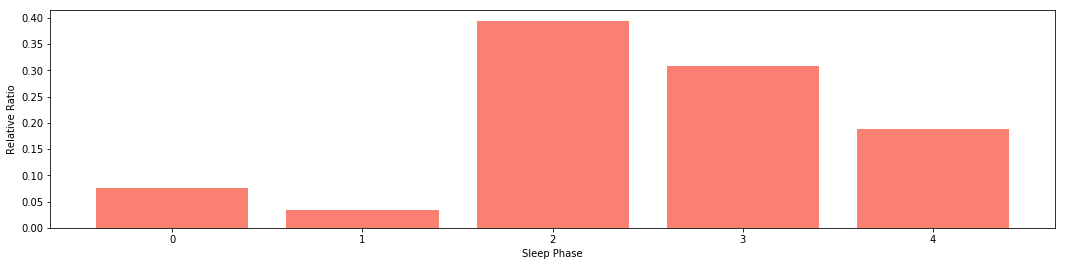

In [82]:
prp = [len(np.where(lbl[msk[:len(lbl)]] == idx)[0]) / len(lbl[msk[:len(lbl)]]) for idx in np.unique(lbl[msk[:len(lbl)]])]

plt.figure(figsize=(18,4))
plt.bar(np.arange(len(prp)), prp, color='salmon')
plt.xlabel('Sleep Phase')
plt.ylabel('Relative Ratio')
plt.show()

In [83]:
print('# General Mask:', len(np.where(np.invert(msk))[0]) / len(msk))
print('# Training Mask:', len(np.where(np.invert(msk[:len(lbl)]))[0]) / len(msk[:len(lbl)]))
print('# Testing Mask:', len(np.where(np.invert(msk[len(lbl):]))[0]) / len(msk[len(lbl):]))

# General Mask: 0.2942162615255658
# Training Mask: 0.2969883641341547
# Testing Mask: 0.2883158508158508


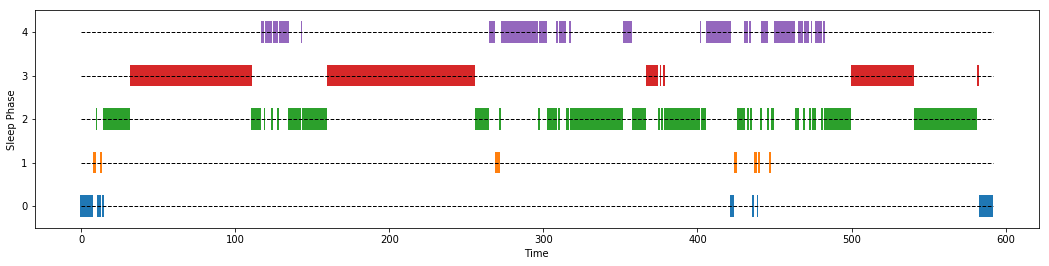

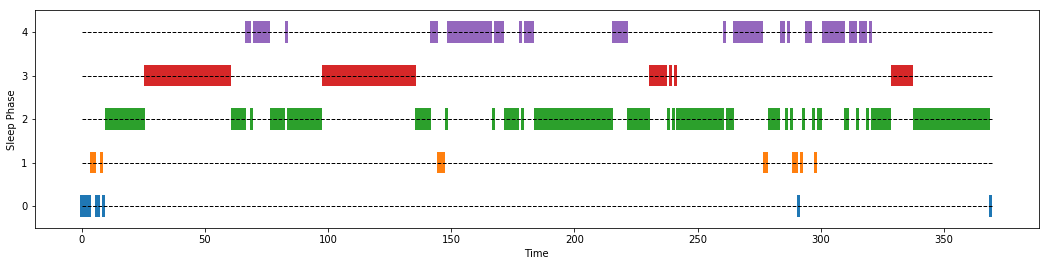

In [87]:
idx = np.random.choice(np.arange(len(mkr)))
beg, end = mkr[idx]
display_profile(prf[idx])
display_profile(prf[idx][msk[beg:end]])

## Feature Development

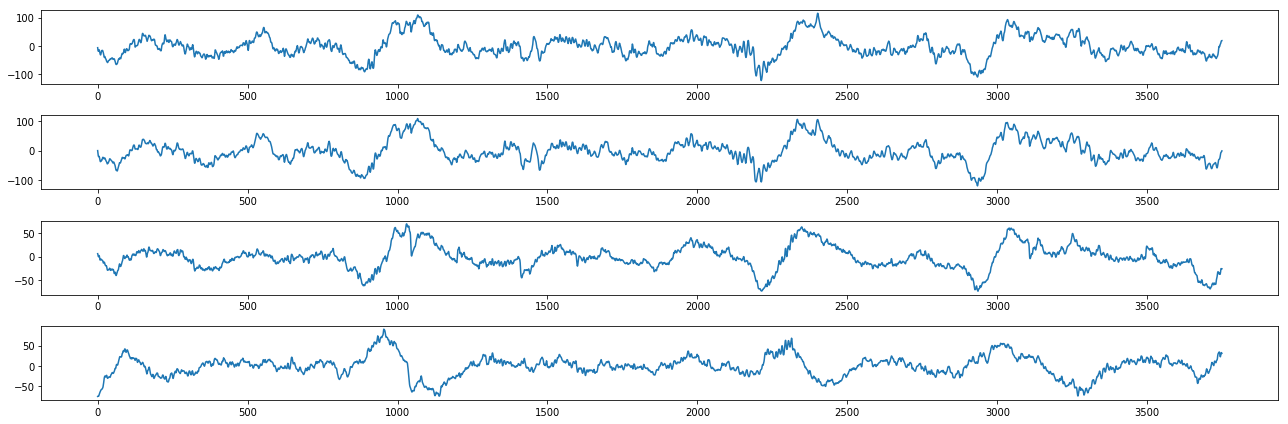

In [158]:
tmp = eeg_s[:,np.random.choice(np.where(msk)[0]),:]

plt.figure(figsize=(18,6))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(tmp[i,:])
plt.tight_layout()
plt.show()

In [159]:
def kalman_filter(val, std_factor=3, smooth_window=5):

    if np.std(val) < 1e-5: 
        return np.zeros(len(val))

    else:
        # Initialize the arrays
        x_t = np.zeros(val.shape[0])
        P_t = np.zeros(val.shape[0])
        x_m = np.zeros(val.shape[0])
        P_m = np.zeros(val.shape[0])
        fac = np.zeros(val.shape[0])
        # Defines the variables
        R = (np.std(val))**2
        Q = (np.std(val) / std_factor)**2
        tmp = np.nanmean(val[:5])
        if np.isnan(tmp): x_t[0] = np.nanmean(val)
        else: x_t[0] = tmp    
        P_t[0] = np.std(val)

        # Iterative construction
        for k in range(1, val.shape[0]):
            x_m[k] = x_t[k-1]
            P_m[k] = P_t[k-1] + Q
            fac[k] = P_m[k] / (P_m[k] + R)
            x_t[k] = x_m[k] + fac[k] * (val[k] - x_m[k])
            P_t[k] = (1 - fac[k]) * P_m[k]

        # Apply smoothing
        b = np.full(smooth_window, 1.0 / smooth_window)
        x_t = sg.lfilter(b, 1, x_t)

        # Memory efficiency
        del P_t, x_m, P_m, fac, R, Q
        
        return x_t

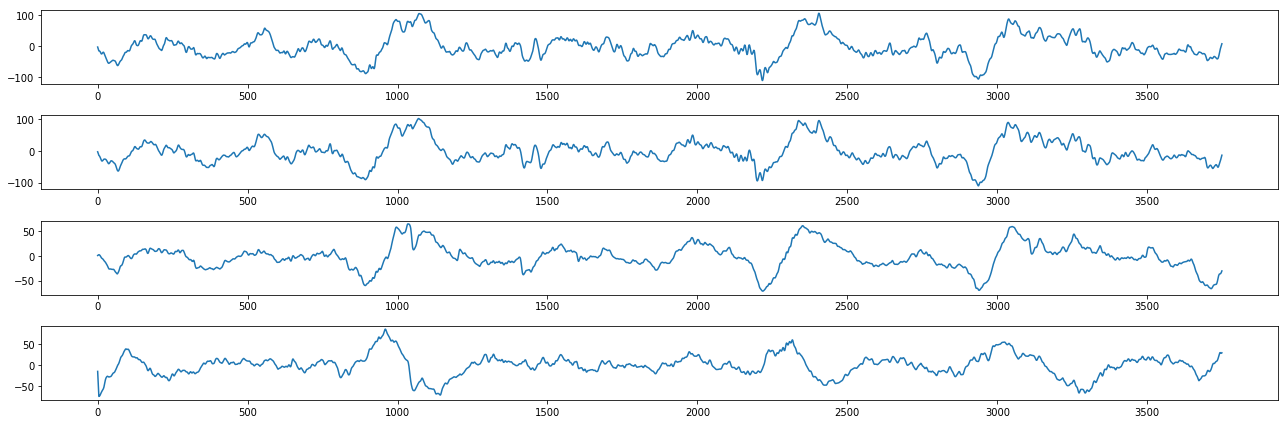

In [165]:
bis = np.asarray([kalman_filter(val) for val in tmp])

plt.figure(figsize=(18,6))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.plot(bis[i,:])
plt.tight_layout()
plt.show()